<a href="https://colab.research.google.com/github/Tamar-m/DeepLearningClass/blob/main/Segformer_Dino_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.2 MB/s eta 0:00:00


In [2]:
from transformers import AutoImageProcessor, SegformerModel, SegformerForSemanticSegmentation, SegformerDecodeHead, SegformerImageProcessor
import torch
import cv2
from torchvision import transforms
from transformers import AdamW
import torch.nn as nn
import math
import os

root_dir = './drive/MyDrive/Deep Learning Class/RAVIR'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # test the model on one image only
# image = cv2.imread("./IR_Case_011.png")

# image_processor = AutoImageProcessor.from_pretrained("nvidia/MiT-b5")
# inputs = image_processor(image, return_tensors="pt")




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
        self.SegformerEncoder = SegformerModel.from_pretrained("nvidia/MiT-b5")
        self.dino_embed_dim = self.dinov2.embed_dim
        self.dino_patch_size = self.dinov2.patch_size
        self.resize = transforms.Resize((448,448))

    def forward(self,x):
      batch_size = x.shape[0]
      with torch.no_grad(): # freeze Dino backbone
        x1 = self.resize(x) # dino input must be a multiple of 14, we choose 448
        final_dim = (x1.shape[2] / self.dino_patch_size, x1.shape[3] / self.dino_patch_size)
        x1 = self.dinov2.forward_features(x1)
        x1 = x1['x_norm_patchtokens'].reshape((batch_size,self.dino_embed_dim,int(final_dim[0]),int(final_dim[1]))) #  calculate dino feature map
      x2 = self.SegformerEncoder(x,output_hidden_states=True)
      y = list(x2.hidden_states) # all segformer hidden states
      y.append(x1) # add dino feature map
      total_encoded = tuple(y)

      return total_encoded

class SegformerMLP(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.proj = nn.Linear(in_features, out_features)

    def forward(self, hidden_states: torch.Tensor):
        hidden_states = hidden_states.flatten(2).transpose(1, 2)
        hidden_states = self.proj(hidden_states)
        return hidden_states

class SegformerDecodeHead(nn.Module):
    def __init__(self, out_channels = 3, num_encoder_blocks = 5, mlp_features=768):
        super(SegformerDecodeHead, self).__init__()
        mlps = []
        for i, in_features in zip(range(num_encoder_blocks),[64, 128, 320, 512,1536]): # feature dimention of each encoder block, last one is dino (1536 for GIANT model and 1024 for LARGE model)
            mlp = SegformerMLP(in_features, mlp_features)
            mlps.append(mlp)
        self.linear_c = nn.ModuleList(mlps)

        # the following 3 layers implement the ConvModule of the original implementation
        self.linear_fuse = nn.Conv2d(
            in_channels=mlp_features * num_encoder_blocks,
            out_channels=mlp_features,
            kernel_size=1,
            bias=False,
        )
        self.batch_norm = nn.BatchNorm2d(mlp_features)
        self.activation = nn.ReLU()

        self.dropout = nn.Dropout(p=0.1, inplace=False)
        self.classifier = nn.Conv2d(mlp_features, out_channels, kernel_size=1)


    def forward(self, encoder_hidden_states: torch.FloatTensor) -> torch.Tensor:
        batch_size = encoder_hidden_states[-1].shape[0]

        all_hidden_states = ()
        for encoder_hidden_state, mlp in zip(encoder_hidden_states, self.linear_c):
            # unify channel dimension
            height, width = encoder_hidden_state.shape[2], encoder_hidden_state.shape[3]
            encoder_hidden_state = mlp(encoder_hidden_state)
            encoder_hidden_state = encoder_hidden_state.permute(0, 2, 1)
            encoder_hidden_state = encoder_hidden_state.reshape(batch_size, -1, height, width)
            # upsample
            encoder_hidden_state = nn.functional.interpolate(
                encoder_hidden_state, size=encoder_hidden_states[0].size()[2:], mode="bilinear", align_corners=False
            )
            all_hidden_states += (encoder_hidden_state,)

        hidden_states = self.linear_fuse(torch.cat(all_hidden_states[::-1], dim=1))
        hidden_states = self.batch_norm(hidden_states)
        hidden_states = self.activation(hidden_states)
        hidden_states = self.dropout(hidden_states)

        # logits are of shape (batch_size, num_labels, height/4, width/4)
        logits = self.classifier(hidden_states)

        return logits

class SegformerDinoV2(nn.Module):
    def __init__(self, out_channels = 3, num_encoder_blocks = 5, mlp_features=768):
        super(SegformerDinoV2, self).__init__()
        self.Encoder = Encoder()
        self.Decoder = SegformerDecodeHead(out_channels=out_channels, num_encoder_blocks = num_encoder_blocks, mlp_features = mlp_features)

    def forward(self,x):
      x = self.Encoder(x)
      output = self.Decoder(x)

      return output

In [5]:
Model = SegformerDinoV2(out_channels=3, num_encoder_blocks = 5, mlp_features=768)
Model.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitg14_pretrain.pth
100%|██████████| 4.23G/4.23G [03:15<00:00, 23.3MB/s]


SegformerDinoV2(
  (Encoder): Encoder(
    (dinov2): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-39): 40 x NestedTensorBlock(
          (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1536, out_features=4608, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1536, out_features=1536, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
          (mlp): SwiGLUFFNFused(
            (w12): Linear(in_features=1536, out_features=8192, bias=True)
            (w3): Linear(in_features=4096, out_features=1536, bias=True)
          )
      

In [ ]:
# output = Model(inputs["pixel_values"])

In [ ]:
# list[output.shape]

list[1, 3, 128, 128]

In [6]:
def dice_coef_loss(predictions, ground_truths, num_classes=2, dims=(1, 2), smooth=1e-8):
    """Smooth Dice coefficient + Cross-entropy loss function."""

    ground_truth_oh = nn.functional.one_hot(ground_truths, num_classes=num_classes)
    prediction_norm = nn.functional.softmax(predictions, dim=1).permute(0, 2, 3, 1)

    intersection = (prediction_norm * ground_truth_oh).sum(dim=dims)
    summation = prediction_norm.sum(dim=dims) + ground_truth_oh.sum(dim=dims)

    dice = (2.0 * intersection + smooth) / (summation + smooth)
    dice_mean = dice.mean()

    CE = nn.functional.cross_entropy(predictions, ground_truths)

    return (1.0 - dice_mean) + CE

In [7]:
# function to train a model
from tqdm.notebook import tqdm

def train_model(model, train_dataset, num_epochs, batch_size, learning_rate, device):
    model.to(device)
    model.train()  # Set the model to training mode

    # Define loss function and optimizer
    #criterion = nn.CrossEntropyLoss()
    learning_rate = learning_rate
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Create DataLoader to load the data in batches
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    pbar = tqdm(train_loader)
    for epoch in range(num_epochs):
        if epoch % 51 == 0:
          learning_rate = learning_rate / 2
          for g in optimizer.param_groups:
            g['lr'] = learning_rate
        total_loss = 0.0
        for idx, batch in enumerate(pbar):
            inputs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(inputs)
            upsampled_logits = nn.functional.interpolate(outputs, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits # upsampled_logits.argmax(dim=1)


            # Compute the loss
            #loss = criterion(predicted, labels)
            loss = dice_coef_loss(upsampled_logits, labels, num_classes=3)

            # Zero the gradients, backward pass, and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Calculate and print average loss for the epoch
        average_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

    print("Training completed.")

In [8]:
# create dataset from RAVIR images
from torch.utils.data import Dataset, DataLoader

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        sub_path = "train" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, sub_path,"images")
        self.ann_dir = os.path.join(self.root_dir, sub_path, "mask")

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)
        # read annotations
        annotation_file_names = []

        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)
        segmentation_map[segmentation_map==128]=1 # the loss in the segformer network only works of the labels are 0,1,2,3,... etc so i changed it
        segmentation_map[segmentation_map==255]=2

        if self.transforms is not None:
            augmented = self.transforms(image=image, mask=segmentation_map)
            encoded_inputs = self.feature_extractor(augmented['image'], augmented['mask'], return_tensors="pt")
        else:
            encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")


        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [9]:
# create training dataset
import albumentations as aug

transform = aug.Compose([
    aug.Flip(p=0.5),
    aug.RandomCrop(width=256, height=256),
    aug.RandomBrightnessContrast(p=0.2),
    aug.SafeRotate(p=0.5)
])

feature_extractor = SegformerImageProcessor(do_resize=False,align=False, reduce_zero_label=False,do_normalize = False)

train_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=transform)

In [10]:
# if not training, load state dict
Model.load_state_dict(torch.load(os.path.join(root_dir,'SegformerDinoV2GIANT_state_dict.pt')))

<All keys matched successfully>

In [ ]:
train_model(model = Model, train_dataset = train_dataset, num_epochs = 600, batch_size = 4, learning_rate = 0.001, device = device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/600], Loss: 1.4290
Epoch [2/600], Loss: 0.9493
Epoch [3/600], Loss: 0.8261
Epoch [4/600], Loss: 0.7822
Epoch [5/600], Loss: 0.7882
Epoch [6/600], Loss: 0.7901
Epoch [7/600], Loss: 0.7166
Epoch [8/600], Loss: 0.6985
Epoch [9/600], Loss: 0.7388
Epoch [10/600], Loss: 0.6528
Epoch [11/600], Loss: 0.6868
Epoch [12/600], Loss: 0.7010
Epoch [13/600], Loss: 0.6768
Epoch [14/600], Loss: 0.7184
Epoch [15/600], Loss: 0.6792
Epoch [16/600], Loss: 0.6492
Epoch [17/600], Loss: 0.6353
Epoch [18/600], Loss: 0.6197
Epoch [19/600], Loss: 0.6525
Epoch [20/600], Loss: 0.6179
Epoch [21/600], Loss: 0.6100
Epoch [22/600], Loss: 0.6058
Epoch [23/600], Loss: 0.6163
Epoch [24/600], Loss: 0.6190
Epoch [25/600], Loss: 0.6563
Epoch [26/600], Loss: 0.6508
Epoch [27/600], Loss: 0.5837
Epoch [28/600], Loss: 0.6022
Epoch [29/600], Loss: 0.6216
Epoch [30/600], Loss: 0.5984
Epoch [31/600], Loss: 0.5948
Epoch [32/600], Loss: 0.5997
Epoch [33/600], Loss: 0.5980
Epoch [34/600], Loss: 0.6130
Epoch [35/600], Loss: 0

tensor(1.)
tensor(0.)
torch.Size([4, 3, 256, 256])


<Figure size 640x480 with 0 Axes>

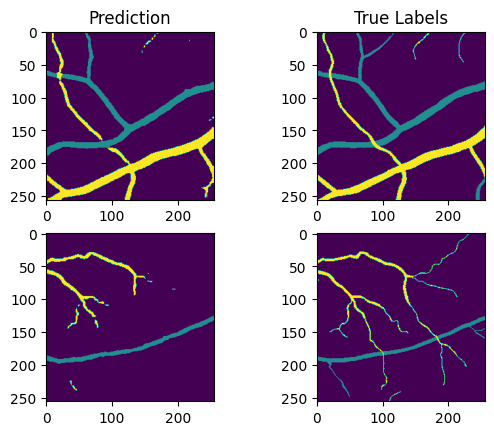

In [12]:
import matplotlib.pyplot as plt

transform_val = aug.Compose([
    aug.RandomCrop(width=256, height=256),
])

valid_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=transform_val, train=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=4)


Model.eval()
with torch.no_grad():
  for idx, batch in enumerate(valid_dataloader):
      pixel_values = batch["pixel_values"].to(device)
      print(torch.max(batch["pixel_values"]))
      print(torch.min(batch["pixel_values"]))
      labels = batch["labels"].to(device)

      outputs = Model(pixel_values)
      print(pixel_values.size())
      upsampled_logits = nn.functional.interpolate(outputs, size=labels.shape[-2:], mode="bilinear", align_corners=False)
      predicted = upsampled_logits.argmax(dim=1)
      mask = (labels != 0) # we don't include the background class in the accuracy calculation
      pred_labels = predicted[mask].detach().cpu().numpy()
      true_labels = labels[mask].detach().cpu().numpy()

plt.figure()
# subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,2)

# display images
axarr[0,0].imshow(predicted[0,:,:].detach().cpu().numpy())
axarr[0,0].title.set_text('Prediction')
axarr[0,1].imshow(labels[0,:,:].detach().cpu().numpy())
axarr[0,1].title.set_text('True Labels')
axarr[1,0].imshow(predicted[1,:,:].detach().cpu().numpy())
axarr[1,1].imshow(labels[1,:,:].detach().cpu().numpy())

In [ ]:
torch.save(Model.state_dict(), os.path.join(root_dir,'SegformerDinoV2GIANT_state_dict.pt'))

In [13]:
# Functions for sliding window method

# Given an image, the following function breaks it into pathces
def get_patches(image, H, W, patch_height, patch_width):
  patches = []

  for y in range(0, H, Hp):
        for x in range(0, W, Wp):
            patch = image[y:y+patch_height, x:x+patch_width, :]
            # print(np.shape(patch))
            # print(type(patch))
            patches.append(patch)

  return patches

# Given a list of patches, this function reconstruct an image
def reconstruct_image(patches, H, W, Hp, Wp):
  # Create an empty canvas to reconstruct the image
  img = np.zeros((H, W), dtype=np.float32)

  index = 0
  for y in range(0, H, Hp):
    for x in range(0, W, Wp):
        img[y:y+Hp, x:x+Wp] = patches[index]
        index += 1

  return img


# Given path to directory with images and patch size, this function return a list of patches per image
def get_all_patches(root_dir, patch_height, patch_width):


  # Create a list of image file names in the directory
  image_dir = os.path.join(root_dir, "images")
  image_file_names = sorted(os.listdir(image_dir))
  image_file_paths = [os.path.join(image_dir, file_name) for file_name in image_file_names]

  all_patches = []
  # Loop over the images, read, divide into patches, and display the patches
  for image_path in image_file_paths:
      # Read the image

      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # Get image dimensions
      height, width, _ = image.shape

      patches = get_patches(image, height, width, patch_height, patch_width)
      all_patches.append(patches)
  return all_patches, image_file_names

# Given an image, this function displays it
def show_image(image):
  plt.imshow(image)
  plt.title("Reconstructed Image")
  plt.axis("off")
  plt.show()

In [14]:
import numpy as np
Hp = 256
Wp = 256

def calc_reconstruct_outputs(root_dir=root_dir,mode="validation"):
  image_dir = root_dir + '/validation' if mode == "validation"  else root_dir + '/test'
  list_of_patches, sorted_file_names = get_all_patches(image_dir, Hp, Wp)

  num_of_images = len(list_of_patches)
  num_of_patches_per_image = len(list_of_patches[0])
  reconstructed_outputs = []

  Model.eval()
  with torch.no_grad():
    for img_index in range(num_of_images):
      patches_orig = np.array(list_of_patches[img_index][:])
      patches = np.moveaxis(patches_orig,3,1).astype('float32')/255
      patches = torch.tensor(patches)
      predicted_patches = np.zeros(np.shape(patches_orig))
      pixel_values = patches.to(device)
      outputs = Model(pixel_values)
      upsampled_logits = nn.functional.interpolate(outputs, size=(256,256), mode="bilinear", align_corners=False)
      predicted = upsampled_logits.argmax(dim=1)
      pred_labels = predicted.detach().cpu().numpy()
      new_image = reconstruct_image(pred_labels, 768, 768, 256, 256)
      reconstructed_outputs.append(new_image)
  return reconstructed_outputs, sorted_file_names

In [ ]:
val_reconstructed_outputs, val_sorted_file_names = calc_reconstruct_outputs(root_dir=root_dir,mode="validation")
test_reconstructed_outputs, test_sorted_file_names = calc_reconstruct_outputs(root_dir=root_dir,mode="test")

In [ ]:
# Dice similarity function
def dice(pred, true, label = 1):
    intersection = np.sum(pred[true==label]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

In [ ]:
# Display some test images and predictions

plt.figure()

f, axarr = plt.subplots(4,2,figsize=(15, 15))
axarr[0,0].title.set_text('Test Image')
axarr[0,1].title.set_text('Predicted Labels')

for i in range(4):
  pixel_vals = cv2.imread(os.path.join(root_dir,'test','images', test_sorted_file_names[i+4]))
  pixel_vals = cv2.cvtColor(pixel_vals, cv2.COLOR_BGR2RGB)
  norm = cv2.normalize(np.moveaxis(pixel_vals,0,-1), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
  axarr[i,0].imshow(pixel_vals)
  axarr[i,0].axis('off')
  axarr[i,1].imshow(test_reconstructed_outputs[i+4])
  axarr[i,1].axis('off')

In [ ]:
# Save test images by name

# Create new directory to save test outputs
new_directory_name = 'Test_eval_Dino_Segformer'
new_directory_path = os.path.join(root_dir,'test', new_directory_name)
os.makedirs(new_directory_path, exist_ok=True)

# Save test outputs
for output, file_name in zip(test_reconstructed_outputs, test_sorted_file_names):
  file_p = os.path.join(root_dir,'test',new_directory_name, file_name)
  output = output * 128
  cv2.imwrite(file_p, output)